# Improved Regularization of Convolutional Neural Networks (Step-6test)

In [ ]:
!pip3 install imagecorruptions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00


## 1. Resnet-20

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F


In [ ]:
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet20(nn.Module):
    def __init__(self):
        super(ResNet20, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self.blocks(16, 16, 3, stride=1)
        self.layer2 = self.blocks(16, 32, 3, stride=2)
        self.layer3 = self.blocks(32, 64, 3, stride=2)
        self.fc = nn.Linear(64, 10)
        self.apply(_weights_init)

    def blocks(self, in_channels, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for i in strides:
            layers.append(ResidualBlock(in_channels, out_channels, i))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

class ResNet20_rot(nn.Module):
    def __init__(self):
        super(ResNet20_rot, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self.blocks(16, 16, 3, stride=1)
        self.layer2 = self.blocks(16, 32, 3, stride=2)
        self.layer3 = self.blocks(32, 64, 3, stride=2)
        self.fc = nn.Linear(64, 10)
        self.fc_rotation = nn.Linear(64, 4) #rotation
        self.apply(_weights_init)

    def blocks(self, in_channels, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for i in strides:
            layers.append(ResidualBlock(in_channels, out_channels, i))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out_classification = self.fc(out)
        out_rotation = self.fc_rotation(out) #rotation
        return out_classification, out_rotation

## 2. Data Processing

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader


normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2023, 0.1994, 0.2010])



val_loader = DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)



100%|██████████| 170498071/170498071 [00:01<00:00, 88268672.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 3. Model Testing with corruption

In [ ]:
from imagecorruptions import corrupt, get_corruption_names
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss().to(device)
model_names = ['resnet.pth','cutout.pth','mixup.pth','rotation.pth','combine.pth']
#model_names = ['rotation.pth','combine.pth']
methods=['gaussian_noise','shot_noise','impulse_noise','brightness','contrast']
models = []
for name in model_names:
    model = ResNet20().to(device) if (name!='rotation.pth') and (name!='combine.pth') else ResNet20_rot().to(device)
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(name)['state_dict'])
    else:
        model.load_state_dict(torch.load(name,map_location=torch.device('cpu'))['state_dict'])
    model.eval()
    models.append(model)

In [ ]:
for corruption in get_corruption_names():
    print(corruption)

In [ ]:
def corrupter(batch,methods,severity=1):
    batch=np.array(batch.permute(0, 2, 3, 1))
    bottom=np.min(batch)
    scope=np.max(batch)-bottom
    batch=np.uint8((batch-bottom)*255/scope)
    batches=[]
    for method in methods:
        new_batch=np.zeros(batch.shape)
        for i in range(batch.shape[0]):
            new_batch[i,:,:,:]=corrupt(batch[i,:,:,:], corruption_name=method, severity=severity)
        new_batch=new_batch/255.*scope+bottom
        new_batch=torch.Tensor(new_batch).permute(0, 3, 1, 2)
        batches.append(new_batch)
    return batches

In [ ]:
for batch_idx, (inputs, targets) in enumerate(val_loader):
    break
batch=np.array(inputs.permute(0, 2, 3, 1))
bottom=np.min(batch)
scope=np.max(batch)-bottom
batch=np.uint8((batch-bottom)*255/scope)
method = 'glass_blur'
new_batch=np.uint8(corrupt(batch[0,:,:,:], corruption_name=method, severity=1))
#plt.imshow(batch[0,:,:,:])
#plt.imshow(new_batch)

In [ ]:
avg_loss = np.zeros((len(models),len(methods)))
avg_acc = np.zeros((len(models),len(methods)))
for model_id in range(len(models)):
    print('model: '+model_names[model_id])
    total_examples = np.zeros(len(methods))
    correct_examples = np.zeros(len(methods))

    val_loss = np.zeros(len(methods))
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs_list = corrupter(inputs,methods)
            targets = targets.to(device)
            for id in range(len(inputs_list)):
                inputs=inputs_list[id].to(device)
                if (model_names[model_id]!='rotation.pth') and (model_names[model_id]!='combine.pth'):
                    outputs = models[model_id](inputs)
                else:
                    outputs,_ = models[model_id](inputs)
                loss = criterion(outputs, targets)
                val_loss[id] += loss.item()
                _, predicted = outputs.max(1)
                total_examples[id] += targets.size(0)
                correct_examples[id] += predicted.eq(targets).sum().item()

    avg_loss[model_id,:] = val_loss / len(val_loader)
    avg_acc[model_id,:] = correct_examples / total_examples

model: rotation.pth


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


model: combine.pth


In [ ]:
avg_loss,avg_acc

(array([[3.71122408, 3.68655519, 2.0071366 , 0.48109204, 0.95082552],
        [2.59544494, 2.52261518, 2.21321885, 0.54791729, 0.89327434]]),
 array([[0.1759, 0.1777, 0.4393, 0.8395, 0.6913],
        [0.2226, 0.2307, 0.3664, 0.8132, 0.6977]]))

In [ ]:
avg_loss,avg_acc

(array([[4.40096726, 4.36244857, 1.91495501, 0.33289557, 0.76132822],
        [5.57776227, 5.73055129, 2.2949255 , 0.26427052, 0.6097013 ],
        [2.09261236, 2.01891635, 1.36277161, 0.28192384, 0.54500702],
        [6.34463289, 5.82436599, 4.29313727, 0.37263876, 0.83148527],
        [3.24409434, 3.40224075, 2.56252543, 0.34695952, 0.60755284]]),
 array([[0.299 , 0.2993, 0.5814, 0.9054, 0.7881],
        [0.2132, 0.2215, 0.4695, 0.9215, 0.8214],
        [0.3647, 0.3822, 0.5938, 0.918 , 0.8356],
        [0.1501, 0.161 , 0.3579, 0.9003, 0.7804],
        [0.1537, 0.1648, 0.3032, 0.8878, 0.7933]]))

In [ ]:
total_examples

array([10000., 10000., 10000., 10000., 10000.])

## 4. adversary attacks

In [ ]:
import attacker

In [ ]:
epsilons = np.linspace(0,0.5,11)
randnoise = np.zeros((len(models),epsilons.shape[0]))
fgsm = np.zeros((len(models),epsilons.shape[0]))
rfgsm = np.zeros((len(models),epsilons.shape[0]))
pgd = np.zeros((len(models),epsilons.shape[0]))

for model_id in range(len(models)):
    print('model: '+model_names[model_id])
    rot=(model_names[model_id]=='rotation.pth') or (model_names[model_id]=='combine.pth')
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        min_v=torch.min(inputs).tolist()
        max_v=torch.max(inputs).tolist()
        scope=max_v-min_v
        min_v-=scope*0.1
        max_v+=scope*0.1
        inputs, targets = inputs.to(device), targets.to(device)

        for eps_id in range(epsilons.shape[0]):
            eps = epsilons[eps_id]
            itr = 10
            alpha = 1.85*(eps/itr)

            adv_inputs = attacker.random_noise_attack(models[model_id], device, inputs, eps,min_v,max_v)
            with torch.no_grad():
                if rot:
                    outputs,_ = models[model_id](adv_inputs)
                else:
                    outputs = models[model_id](adv_inputs)
                _, predicted = outputs.max(1)
                randnoise[model_id,eps_id] += predicted.eq(targets).sum().item()

            adv_inputs = attacker.FGSM_attack(models[model_id], device, inputs, targets, eps,min_v,max_v,rot)
            with torch.no_grad():
                if rot:
                    outputs,_ = models[model_id](adv_inputs)
                else:
                    outputs = models[model_id](adv_inputs)
                _, predicted = outputs.max(1)
                fgsm[model_id,eps_id] += predicted.eq(targets).sum().item()

            adv_inputs = attacker.rFGSM_attack(models[model_id], device, inputs, targets, eps,min_v,max_v,rot)
            with torch.no_grad():
                if rot:
                    outputs,_ = models[model_id](adv_inputs)
                else:
                    outputs = models[model_id](adv_inputs)
                _, predicted = outputs.max(1)
                rfgsm[model_id,eps_id] += predicted.eq(targets).sum().item()

            adv_inputs = attacker.PGD_attack(models[model_id], device, inputs, targets, eps, alpha, itr, False,min_v,max_v,rot)
            with torch.no_grad():
                if rot:
                    outputs,_ = models[model_id](adv_inputs)
                else:
                    outputs = models[model_id](adv_inputs)
                _, predicted = outputs.max(1)
                pgd[model_id,eps_id] += predicted.eq(targets).sum().item()


randnoise/=10000
fgsm/=10000
rfgsm/=10000
pgd/=10000

model: rotation.pth
model: combine.pth


In [ ]:
randnoise,fgsm,rfgsm,pgd

(array([[0.9145, 0.912 , 0.8993, 0.8802, 0.8519, 0.8164, 0.7651, 0.7059,
         0.6467, 0.5806, 0.5152],
        [0.9285, 0.9229, 0.9063, 0.8739, 0.8276, 0.762 , 0.6867, 0.6007,
         0.521 , 0.438 , 0.3822],
        [0.9252, 0.9222, 0.9147, 0.8945, 0.8664, 0.8202, 0.7755, 0.7129,
         0.6476, 0.5911, 0.5286],
        [0.9092, 0.8968, 0.859 , 0.7842, 0.7004, 0.5971, 0.5004, 0.4182,
         0.341 , 0.2846, 0.2418],
        [0.8918, 0.8777, 0.8345, 0.7669, 0.6884, 0.5978, 0.5087, 0.4204,
         0.3427, 0.2808, 0.2333]]),
 array([[0.9145, 0.2079, 0.1527, 0.1321, 0.1151, 0.1102, 0.1013, 0.1   ,
         0.0979, 0.0961, 0.0938],
        [0.9285, 0.2089, 0.1498, 0.1286, 0.1148, 0.1004, 0.0938, 0.0925,
         0.09  , 0.0912, 0.0925],
        [0.9252, 0.4905, 0.4481, 0.4031, 0.3479, 0.2987, 0.2584, 0.2314,
         0.2109, 0.191 , 0.1778],
        [0.9092, 0.1741, 0.1475, 0.1359, 0.1237, 0.1203, 0.1162, 0.1133,
         0.1118, 0.1052, 0.1028],
        [0.8918, 0.2078, 0.1817, 0.

In [ ]:
randnoise,fgsm,rfgsm,pgd

(array([[0.8476, 0.834 , 0.8088, 0.762 , 0.6972, 0.6212, 0.5389, 0.4644,
         0.3925, 0.3315, 0.2871],
        [0.8254, 0.8102, 0.771 , 0.7158, 0.6505, 0.5776, 0.5138, 0.4489,
         0.397 , 0.3497, 0.3077]]),
 array([[0.8476, 0.1115, 0.099 , 0.0979, 0.1016, 0.1055, 0.1127, 0.114 ,
         0.116 , 0.1156, 0.1146],
        [0.8254, 0.1468, 0.1146, 0.1099, 0.1047, 0.1039, 0.1014, 0.0996,
         0.0973, 0.0952, 0.095 ]]),
 array([[0.8476, 0.1042, 0.0473, 0.0317, 0.0283, 0.0287, 0.0298, 0.0322,
         0.0363, 0.0418, 0.053 ],
        [0.8254, 0.1441, 0.0696, 0.0486, 0.0388, 0.036 , 0.0359, 0.0334,
         0.0347, 0.032 , 0.0313]]),
 array([[8.476e-01, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [8.254e-01, 5.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]]))

In [ ]:
import matplotlib.pyplot as plt

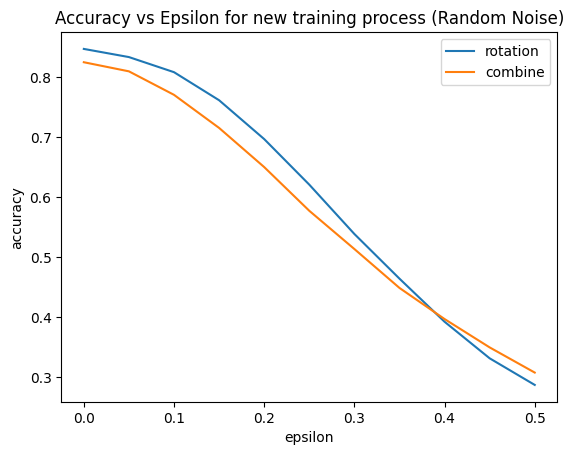

In [ ]:
for m in range(len(models)):
    plt.plot(epsilons,randnoise[m,:],label=model_names[m][:-4])
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.title('Accuracy vs Epsilon for new training process (Random Noise)')
plt.legend()
plt.show()

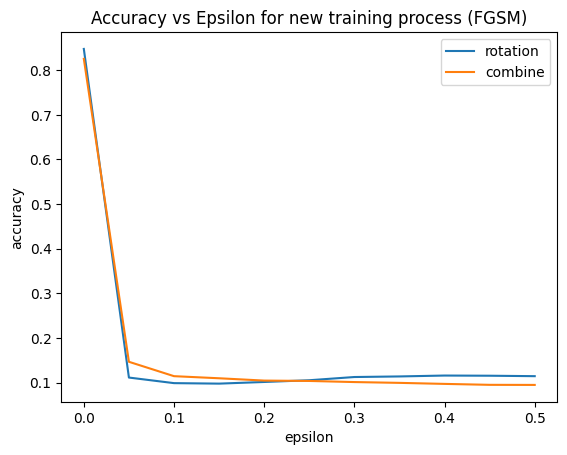

In [ ]:
for m in range(len(models)):
    plt.plot(epsilons,fgsm[m,:],label=model_names[m][:-4])
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.title('Accuracy vs Epsilon for new training process (FGSM)')
plt.legend()
plt.show()

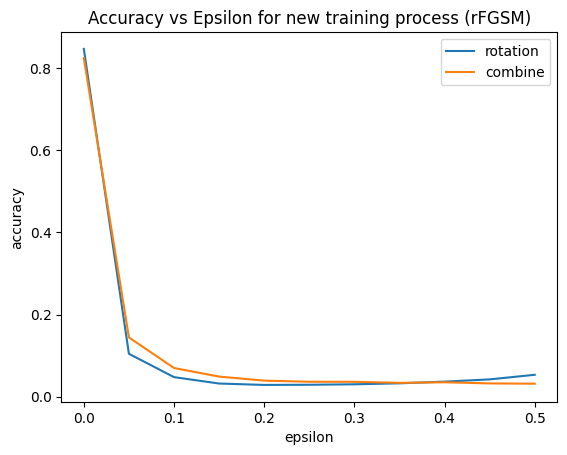

In [ ]:
for m in range(len(models)):
    plt.plot(epsilons,rfgsm[m,:],label=model_names[m][:-4])
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.title('Accuracy vs Epsilon for new training process (rFGSM)')
plt.legend()
plt.show()

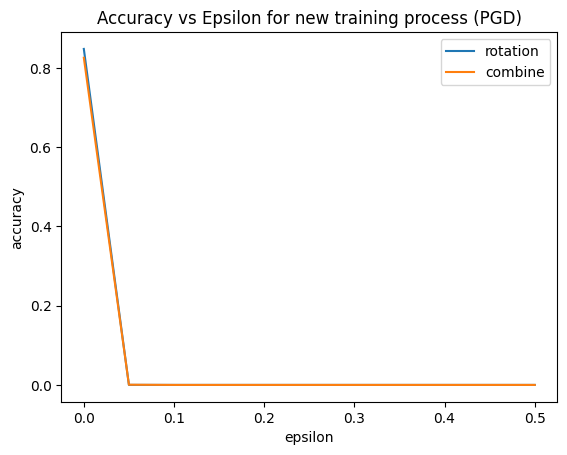

In [ ]:
for m in range(len(models)):
    plt.plot(epsilons,pgd[m,:],label=model_names[m][:-4])
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.title('Accuracy vs Epsilon for new training process (PGD)')
plt.legend()
plt.show()